In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with one-hot NAICS Clusters (DGI Label)
XGBoost model, one hot encoded values from k means clustering

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

##### Get loans data, append clusters

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
sba_loans.filter(like='NAICS').columns

Index(['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc', 'NAICS_num',
       'menc_NAICS', 'cenc_NAICS', 'menc_grp_NAICS'],
      dtype='object')

In [8]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('69_DATA_embeddings_tsne_naics.parquet'))

In [9]:
clus_cols = [c for c in embed_df if c.startswith('NC__')]
len(clus_cols)

9

In [10]:
sba_loans = sba_loans.drop(columns = clus_cols, errors='ignore') \
    .merge(embed_df[clus_cols + ['NAICS_orig']].rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

In [11]:
sba_loans[clus_cols].describe()

,NC__0,NC__1,NC__2,NC__3,NC__4,NC__5,NC__6,NC__7,NC__8
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.051148,0.138202,0.173180,0.137141,0.075061,0.113975,0.072882,0.231823,0.006588
std,0.220300,0.345112,0.378403,0.343996,0.263490,0.317781,0.259944,0.421997,0.080898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [13]:
train_df.shape

(425594, 59)

#### Set the predictor features.  Include one-hot NAICS

In [14]:
predictor_features = setup.predictor_features + clus_cols
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'NC__0', 'NC__1', 'NC__2', 'NC__3', 'NC__4', 'NC__5', 'NC__6', 'NC__7', 'NC__8']


In [15]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NC__0,NC__1,NC__2,NC__3,NC__4,NC__5,NC__6,NC__7,NC__8,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,0.017246,-0.005922,-0.001250,0.020189,0.017581,-0.006991,0.003552,-0.032216,0.025830,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.017793,-0.003452,-0.010563,-0.013908,0.039583,-0.013499,0.025724,-0.017896,0.009498,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.045582,-0.047976,0.070390,0.081272,-0.008493,0.030051,-0.022973,-0.066838,-0.005747,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,0.218329,-0.042845,0.034596,0.032656,0.032128,-0.018894,0.002811,-0.153467,0.045094,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,-0.029171,-0.019258,0.022708,-0.054002,0.024105,-0.003393,0.049287,0.015329,-0.015823,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,-0.049097,0.011438,-0.020522,-0.016507,-0.017095,0.027934,-0.004944,0.039212,-0.011648,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,0.053674,-0.032670,-0.039633,-0.033608,0.025620,-0.035184,0.173259,-0.030821,-0.016743,-0.011047
NC__0,0.017246,0.017793,-0.045582,0.218329,-0.029171,-0.049097,0.053674,1.000000,-0.095448,-0.106851,-0.093541,-0.067488,-0.085572,-0.065568,-0.131290,-0.019420,-0.034754
NC__1,-0.005922,-0.003452,-0.047976,-0.042845,-0.019258,0.011438,-0.032670,-0.095448,1.000000,-0.181723,-0.159087,-0.114779,-0.145534,-0.111512,-0.223287,-0.033029,0.049247
NC__2,-0.001250,-0.010563,0.070390,0.034596,0.022708,-0.020522,-0.039633,-0.106851,-0.181723,1.000000,-0.178092,-0.128491,-0.162921,-0.124834,-0.249963,-0.036975,-0.085665


In [16]:
with open(Path(setup.temp_path).joinpath('70_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [17]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [18]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [19]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators)

In [20]:
xgb_model = xgb_model.set_params(**xgb_params)

In [21]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49986	validation_1-logloss:0.50273
[1]	validation_0-logloss:0.49362	validation_1-logloss:0.49649
[2]	validation_0-logloss:0.48841	validation_1-logloss:0.49128
[3]	validation_0-logloss:0.48395	validation_1-logloss:0.48683
[4]	validation_0-logloss:0.48009	validation_1-logloss:0.48297
[5]	validation_0-logloss:0.47676	validation_1-logloss:0.47961
[6]	validation_0-logloss:0.47383	validation_1-logloss:0.47669
[7]	validation_0-logloss:0.47135	validation_1-logloss:0.47426
[8]	validation_0-logloss:0.46931	validation_1-logloss:0.47223
[9]	validation_0-logloss:0.46747	validation_1-logloss:0.47042
[10]	validation_0-logloss:0.46587	validation_1-logloss:0.46887
[11]	validation_0-logloss:0.46447	validation_1-logloss:0.46752
[12]	validation_0-logloss:0.46332	validation_1-logloss:0.46640
[13]	validation_0-logloss:0.46235	validation_1-logloss:0.46544
[14]	validation_0-logloss:0.46145	validation_1-logloss:0.46459
[15]	validation_0-logloss:0.46070	validation_1-logloss:0.46385
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Save the model

In [22]:
xgb_model.save_model(Path(setup.temp_path).joinpath('70_MODEL_xgboost.json'))

In [23]:
with open(Path(setup.temp_path).joinpath('70_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [24]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [25]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.187005,0.107667,0.016765,0.661832,0.181112
1,0.270142,0.095391,0.016765,0.673198,0.279994


## Decision Threshold
Max f1, on training data

In [26]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [27]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [28]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('70_REPORT_thresh_tune.csv'), index=False)

In [29]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.437069
12,0.24,0.436579


##### Apply decision threshold
All datasets

In [30]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [31]:
pred_df['predict_bin'].value_counts()

predict_bin
0    358024
1    330057
Name: count, dtype: int64

In [32]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('70_DATA_combined_predictions.parquet'))

## Metrics

In [33]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('70_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.617497,0.432836,0.307986,0.727914,0.358211,0.715724,NaN
1,train,0.614802,0.437069,0.310760,0.736367,0.361232,0.715911,NaN
2,val,0.614744,0.438649,0.313069,0.732453,0.359524,0.713671,NaN
0,test,0.613411,0.435064,0.309740,0.730722,0.361710,0.714090,0.0
1,test,0.630143,0.425508,0.302232,0.718627,0.346136,0.720058,1.0


## Lift
Test data

In [34]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

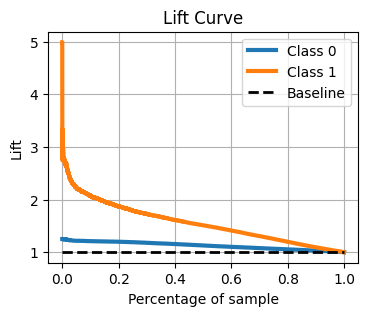

In [35]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('70_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [36]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [37]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('70_REPORT_importance_gain.csv'), index=True)

In [38]:
feat_impgain.head()

,importance
urban_flag,760.420532
LowDoc,137.532516
DisbursementGross,72.326286
NC__7,57.344418
NC__1,32.705101


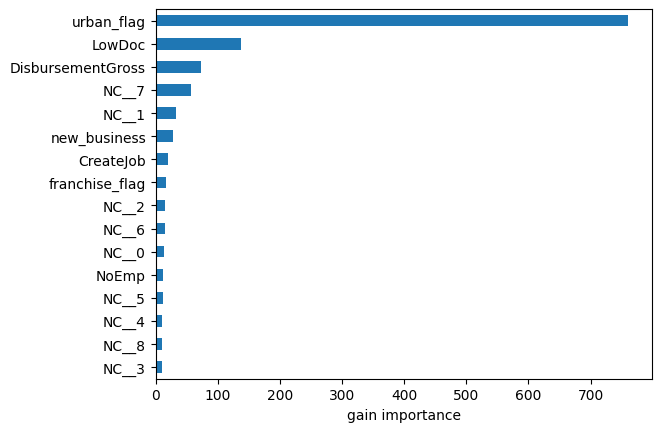

In [39]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('70_PLOT_importance_gain.png'))

##### Permutation Importance

In [40]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [41]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [42]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.080473,0.080473
5,urban_flag,0.039080,0.039080
1,CreateJob,0.028968,0.028968
14,NC__7,0.015297,0.015297
2,LowDoc,0.014841,0.014841


In [43]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('70_DATA_importance_perturb.csv'),
            index=False)

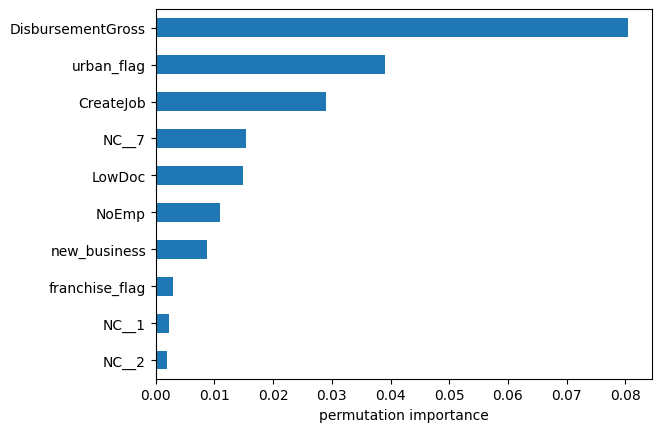

In [44]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('70_PLOT_importance_perturb.png'))

## PDP Plot - One Hot

In [45]:
naics_features = list(train_df.filter(like='NC_').columns)

In [46]:
plt.close()

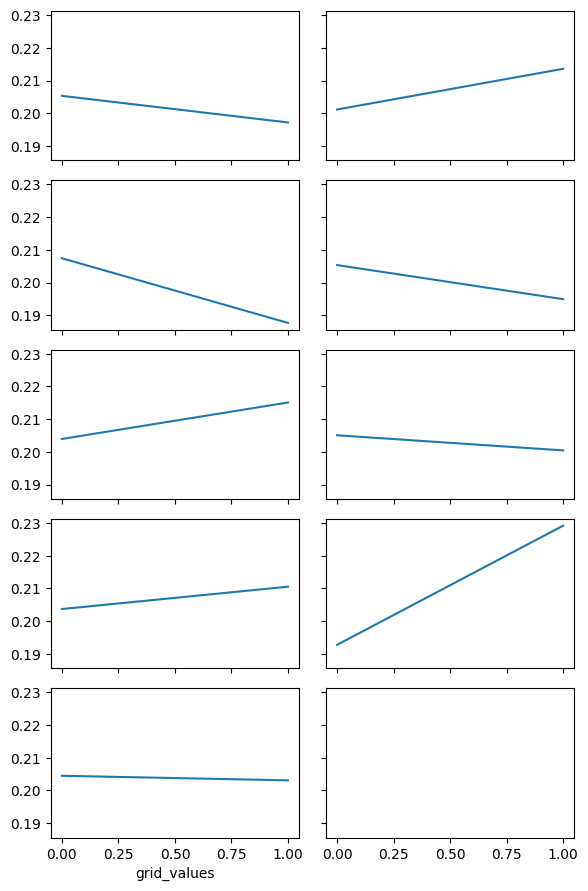

In [47]:
fig, ax = plt.subplots(int(np.ceil(len(naics_features)/2)), 2, sharex=True, sharey=True, figsize=(6, 9))
for i in range(len(naics_features)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    results = partial_dependence(xgb_model, train_df[predictor_features], 
                                 [naics_features[i]])
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('70_PLOT_pdp_naics_onehot.png'),
               bbox_inches='tight')
plt.show()